# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [423]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import emoji
import time
import joblib

## data preprocessing and validation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.datasets import dump_svmlight_file

## classifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## boosting algos
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

## metrics to validate the model
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

## customer segmentation
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

sns.set(style="whitegrid")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [375]:
## Constants

# Different types of columns to handle in different ways
mixed_type_cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
more_than_20_cols =  ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2',
                            'ALTER_KIND1', 'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP',
                            'KBA05_BAUMAX', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
                            'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE',
                            'D19_VERSAND_ONLINE_QUOTE_12', 'D19_LOTTO',
                            'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12',
                            'D19_BANKEN_ONLINE_QUOTE_12', 'D19_SOZIALES',
                            'D19_VERSI_ONLINE_QUOTE_12']
remove_cols = ["CAMEO_INTL_2015", "CAMEO_DEU_2015","LNR"]

# "LP_LEBENSPHASE_FEIN","LP_STATUS_FEIN", "LP_FAMILIE_FEIN",
## extra columns to remove from the dataset
extra_cols = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

column_types_dict = {
    "mixed_cols" : mixed_type_cols,
    "missing_cols" : more_than_20_cols,
    "remove_cols" : remove_cols,
    "extra_cols" : extra_cols
}

# random seed 
rand_seed = 42

## imputer object
imputer = SimpleImputer(strategy="most_frequent")


## Standard scalar object
std_scalar = StandardScaler()

## Important Functions

In [378]:
# to drop unnamed columns
def drop_unnamed_cols(cols):
    """
    Function to find columns with named "unnamed" and drop them.
    
    Args:
        cols (list) : columns list
    Returns:
        cols (list) : updated column list
    """
    return cols[cols.str.contains("Unnamed")]


def get_data_information():
    """
    Function to load the data dictionary files and cleaning them
    
    Args: None
    Returns:
        data_dict (dataframe) : Data dictionary with all the Attributes name, description
        data_cat_lavels (dataframe) : All the unique category values for all the categorical columns.
        
    """
    
    # getting data dictionary
    data_dict = pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx",skiprows=1)
    data_dict = data_dict.drop(columns= drop_unnamed_cols(data_dict.columns))
    data_dict.loc[:,"Information level"] = data_dict["Information level"].fillna(method="ffill").fillna(method="bfill").values

    # getting categorical levels info
    data_cat_lavels = pd.read_excel("DIAS Attributes - Values 2017.xlsx",skiprows=1)
    data_cat_lavels = data_cat_lavels.drop(columns= drop_unnamed_cols(data_cat_lavels.columns))
    data_cat_lavels = data_cat_lavels.fillna(method="ffill").fillna(method="bfill")
    
    return data_dict, data_cat_lavels


def load_dataset(dataset_name, cleaned = False ,scaled = False):
    """
    Function to load the datasets
    
    Args: 
        dataset_name (string) : a dataset name
        cleaned (bool) : boolean to get the cleaned data
        scaled (bool) : boolean to get the scaled data
    Returns:
        df (dataframe) : Dataframe based on the conditions.
        
    """
    
    if scaled:
        try:
            ## read scaled data
            df = pd.read_csv(f'data/{dataset_name}_scaled.csv')
        except FileNotFoundError:
            print(f' couldn\'t find scaled dataset for {dataset_name} !!')
    elif cleaned:
        try:
            ## read cleaned data
            df = pd.read_csv(f'data/{dataset_name}_cleaned.csv')
        except FileNotFoundError:
            print(f' couldn\'t find cleaned dataset for {dataset_name} !!')
    else:
        try:
            ## read raw data
            df = pd.read_csv(f'data/Udacity_{dataset_name}_052018.csv', sep=";")
        except FileNotFoundError:
            print(f' couldn\'t find any dataset for {dataset_name} !!')
    
    return df

def data_preprocessing(df, dataset_name, mapping_unknow_values, cols_dict, std_scalar, imputer, fitted = False , row_missing_thre = 0.2, remove_miss_rows = True):
    """
    Function to preprocess the datasets, by removing unnecessary columns, 
    doing feature engineering, and encoding the categorical columns , imputing missing values and stardizing the whole data.
    Args:
        df (dataframe) : dataset
        dataset_name (string) : dataset name
        mapping_unknow_values (dataframe) : a Mapping with unknown informations
        cols_dict (dict) : dictionary with list of columns 
        std_scalar (object) : Standard Scalar object 
        imputer (object) : Missing value imputer object
        fitted (bool) : scalar and imputer objects are fitted or not
        row_missing_thre (float) : threshold for missing number of rows
        remove_miss_rows (bool) : boolean to remove missing rows or not
    Returns:
        scaled_df (Dataframe) : Standard scaled dataframe 
    """
    
    start_time = time.perf_counter()
    
    rows, cols = df.shape
    print(f" Total columns :- {cols} and total rows :- {rows} ")
        
    print(f" fixing some Mixed data types ... (2)")
    ## fixing mixed data types
    for col in cols_dict["mixed_cols"]:
        df[col] = pd.to_numeric(df[col],errors="coerce")
        
    print(f" replacing unknonw values to NaN ... (3)")
    ## replacing unknown values to NaN
    df_unk_cols = df.columns[df.columns.isin(mapping_unknow_values.keys())]

    for col in df_unk_cols:
        for replace_val in mapping_unknow_values[col]:
            df.loc[:,col] = df[col].replace(float(replace_val),np.nan)
    
    print(f" dropping high percentage missing values by columns ... (4)")
    ## dropping high percentage missing values by columns
    df = df.drop(columns = cols_dict["missing_cols"])

    if remove_miss_rows:
        print(f" dropping high percentage missing values by rows ... (5)")
        ## dropping high percentage missing values by rows
        df = df.dropna(thresh= int(df.shape[1] * (1 - row_missing_thre)))
    else:
        print(f" skipped missing values by rows ... (5)")


    print(f" converting date columns to datetime format ... (6)")
    ## converting to datetime format
    df.loc[:,"EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"]).values
    df.loc[:,"EINGEFUEGT_AM_YEAR"] = df["EINGEFUEGT_AM"].dt.year.values
    df.loc[:,"EINGEFUEGT_AM_MONTH"] = df["EINGEFUEGT_AM"].dt.month.values
    df = df.drop(columns = ["EINGEFUEGT_AM"])

    print(f" Fixing and encoding values for some columns ... (7)")
    ## replacing "uniformly distributed" value to randomly between other classes
    df.loc[df["ALTERSKATEGORIE_GROB"] == 9, "ALTERSKATEGORIE_GROB"]  = np.random.randint(low=1,high=4,size=df["ALTERSKATEGORIE_GROB"].value_counts()[9])

    ## saperating two columns from one 
    df.loc[:,"CAMEO_INTL_2015_FAMILY"] = df["CAMEO_INTL_2015"].apply(lambda x : x%10 if x != np.nan else x)
    df.loc[:,"CAMEO_INTL_2015_WEALTH"] = np.floor(df["CAMEO_INTL_2015"].apply(lambda x : (x/10.0) if x is not np.nan else x).values)

    ## encoding from object to numeric form
    df.loc[:,"OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W" : 1, "O":0}).values
    
    print(f" removing unnecessary columns ... (8)")
    ## removing columns
    df = df.drop(columns= cols_dict["remove_cols"])

    
    
    ## Transform the data if fitted model is there otherwise fit and transform data with the model

    if fitted:
        print(" imputing missing values based on 'most frequent' method ... (9)")
        ## imputing missing values based on "most frequent" method
        df = pd.DataFrame(imputer.transform(df), columns = df.columns)
        
        print(" Saving cleaned dataset in CSV format ... (10)")
        df.to_csv(f'data/{dataset_name}_cleaned.csv', index=False)
        
        

        print(" Standardizing all the values from -1 to 1 ... (11)")
        ## Standardizing all the values from -1 to 1
        df = pd.DataFrame(std_scalar.transform(df), columns = df.columns)
        
        print(" Saving scaled dataset in CSV format ... (12)")
        df.to_csv(f'data/{dataset_name}_scaled.csv', index=False)
    else:
        print(" imputing missing values based on 'most frequent' method ... (9)")
        ## imputing missing values based on "most frequent" method
        df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
        joblib.dump(imputer, "models/Missing_data_imputer_model.pkl")
        
        print(" Saving cleaned dataset in CSV format ... (10)")
        df.to_csv(f'data/{dataset_name}_cleaned.csv', index=False)
        
        print(" Standardizing all the values from -1 to 1 ... (11)")
        ## Standardizing all the values from -1 to 1
        df = pd.DataFrame(std_scalar.fit_transform(df), columns = df.columns)
        joblib.dump(std_scalar, "models/Scaling_data_model.pkl")
        
        print(" Saving scaled dataset in CSV format ... (12)")
        df.to_csv(f'data/{dataset_name}_scaled.csv', index=False)
    
    end_time = time.perf_counter()
    print(f" Total time took to get scaled {dataset_name} dataset is { round((end_time - start_time)/60,2) } mins... ")
    
    return df,std_scalar, imputer

In [379]:
data_dict, data_cat_lavels = get_data_information()

# getting unknown labels and converting them in a list to convert into np.nan 
unknown_attrs = data_cat_lavels[(data_cat_lavels.Meaning.str.contains("unknown"))]
unknown_attrs.loc[ :, "Value"] = unknown_attrs.Value.apply(lambda x : str(x).replace(" ","").split(",")).values
mapping_unknow_values = unknown_attrs.set_index("Attribute")["Value"].to_dict()
unknown_attrs.head()

/opt/anaconda3/envs/pyds/lib/python3.7/site-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,[-1],unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]",unknown
11,ALTER_HH,main age within the household,[0],unknown / no main age detectable
33,ANREDE_KZ,gender,"[-1, 0]",unknown
40,BALLRAUM,distance to next urban centre,[-1],unknown


In [380]:
## cleaning processs

## load Azdias dataset
dataset_name = "AZDIAS"

print(f"Loading {dataset_name} dataset ... (1)")
azadias_df = load_dataset(dataset_name)

## cleaning the dataset
scaled_azdias, std_scalar, imputer = data_preprocessing(azadias_df, dataset_name , mapping_unknow_values, column_types_dict, std_scalar,imputer, fitted=False)


## Load Customers dataset
dataset_name = "CUSTOMERS"

print(f"Loading {dataset_name} dataset ... (1)")    
customers_df = load_dataset(dataset_name)

customers_extra_df = customers_df[extra_cols]

## cleaning the dataset
scaled_customers,std_scalar, imputer = data_preprocessing(customers_df, dataset_name , mapping_unknow_values, column_types_dict, std_scalar,imputer, fitted=True)


Loading AZDIAS dataset ... (1)


/opt/anaconda3/envs/pyds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


 Total columns :- 366 and total rows :- 891221 
 fixing some Mixed data types ... (2)
 replacing unknonw values to NaN ... (3)
 dropping high percentage missing values by columns ... (4)
 dropping high percentage missing values by rows ... (5)
 converting date columns to datetime format ... (6)
 Fixing and encoding values for some columns ... (7)
 removing unnecessary columns ... (8)
 imputing missing values based on 'most frequent' method ... (9)
 Standardizing all the values from -1 to 1 ... (11)
 Total time took to get scaled AZDIAS dataset is 1.05 mins... 


In [383]:
scaled_azdias.shape, scaled_customers.shape 

(779135, 346)

In [385]:
scaled_azdias.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_S

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [6]:

## load scaled datasets
azadias_df = load_dataset("AZDIAS", scaled=True)
customers_df = load_dataset("CUSTOMERS", scaled=True)

In [7]:
azadias_df.shape , customers_df.shape

((779135, 343), (139521, 343))

### Dimentionality reduction using PCA (Principal Componant Analysis)

This is to reduce the number of features or dimensions, which does not vary too much, that we can check using the PCA. which is a very popular statistcal approach to verify the explained variance by each features. So, let's start.

In [10]:
## ininialize the PCA object and fitting them with Azdias scaled dataset
pca = PCA( random_state = rand_seed)
princi_comp = pca.fit_transform(azadias_df)
princi_df = pd.DataFrame(data = princi_comp)

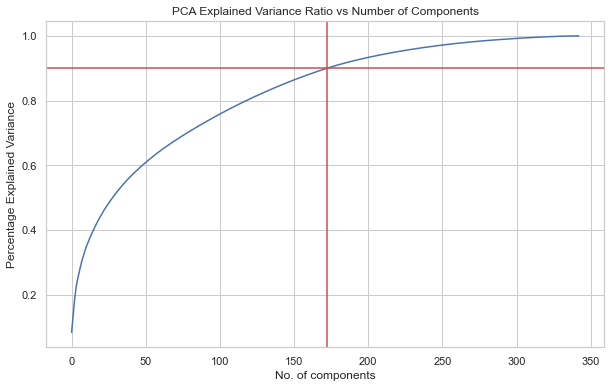

In [35]:
fig = plt.figure(figsize=(10,6))

cumulative_variance_explnd = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance_explnd)
plt.xlabel("No. of components")
plt.ylabel("Percentage Explained Variance")
plt.title("PCA Explained Variance Ratio vs Number of Components")
plt.axhline(y=0.9, color="r")
plt.axvline(x=172, color="r")
plt.show()

From the above plot we can say that to explain 90% variace we can set number of componants to 172 and perform the PCA Analysis.

In [38]:
## n_components considered as a final dimensions in PCA
pca = PCA( n_components=174 ,random_state= 42)
princi_comp = pca.fit_transform(azadias_df)
azdias_princi_df = pd.DataFrame(data = princi_comp)


In [216]:
## features list
features_list = azadias_df.columns


def pca_analysis(pca, dimension, features_list, data_dict, draw = True):
    """
    Function to do analysis completely on PCA componenets vs the features list,
    Args:
        pca (object) : PCA object
        dimension (int) : dataset name
        features_list (list) : List of feature names
        data_dict (dict) : dictionary with list of columns 
        draw (bool) : whether to draw plots or not
    Returns:
        pca_feature_info_tailed (Dataframe) : dataframe
    """
    components = pca.components_
    feature_weights = pd.DataFrame(zip(features_list, components[dimension]),columns=["Attribute","feature_weights"])

    pca_feature_info = data_dict.loc[data_dict["Attribute"].isin(features_list),["Attribute","Description"]].merge(feature_weights, on="Attribute").sort_values("feature_weights", ascending=False )
    pca_feature_info_tailed = pd.concat([pca_feature_info.head(),pca_feature_info.tail()])
    
    if draw:
        fig = plt.figure(figsize=(8,6))
        sns.barplot(x="Attribute" , y= "feature_weights",data=pca_feature_info_tailed)
        plt.xticks(rotation=45)
        plt.plot();
    
    return pca_feature_info_tailed


,Attribute,Description,feature_weights
242,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.137223
134,MOBI_REGIO,moving patterns,0.131068
16,LP_STATUS_GROB,social status rough,0.126746
76,KBA05_AUTOQUOT,share of cars per household,0.125147
143,KBA13_AUTOQUOTE,share of cars per household within the PLZ8,0.124844
39,HH_EINKOMMEN_SCORE,estimated household_net_income,-0.126244
66,CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,-0.129084
246,PLZ8_BAUMAX,most common building-type within the PLZ8,-0.130010
245,PLZ8_ANTG4,number of >10 family houses in the PLZ8,-0.131284
244,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.136420


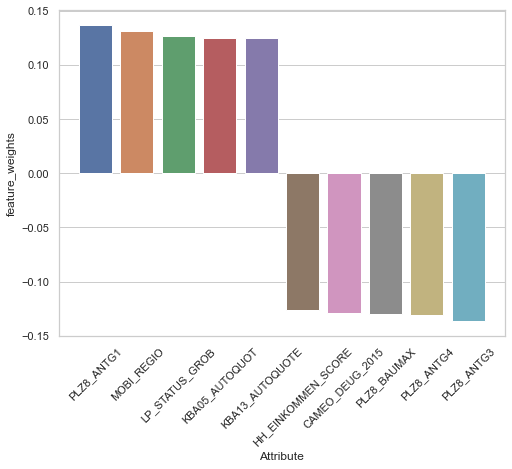

In [104]:
pca_analysis(pca,0,features_list,data_dict)

Component 0:

1. number of 1-2 family houses in the PLZ8 has positive weights where more than 6 family houses it have negative weights
2. most common building-type within the PLZ8 has negative weights too

,Attribute,Description,feature_weights
178,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.171538
211,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.148510
225,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper cla...,0.145167
150,KBA13_BMW,share of BMW within the PLZ8,0.141030
232,KBA13_SITZE_4,number of cars with less than 5 seats in the PLZ8,0.134379
166,KBA13_HALTER_25,share of car owners between 21 and 25 within t...,-0.116178
184,KBA13_KMH_180,share of cars with max speed between 110 km/h ...,-0.117108
186,KBA13_KMH_140_210,share of cars with max speed between 140 and 2...,-0.123954
220,KBA13_SEG_KLEINWAGEN,share of small and very small cars (Ford Fiest...,-0.125300
233,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.140848


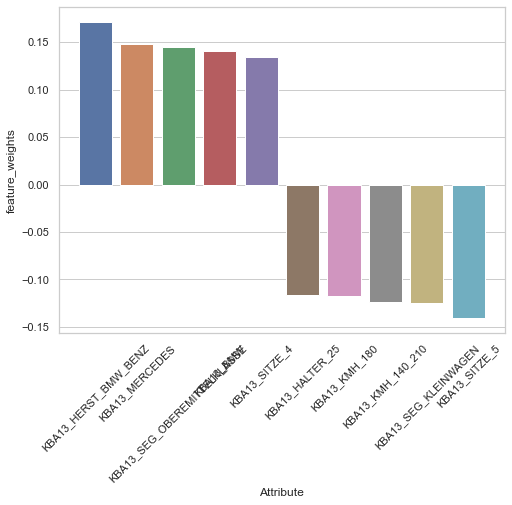

In [108]:
pca_analysis(pca,1,features_list,data_dict)

Component : 1 

This one is very  interesting, here we can clearly notice that for laxurious car the weights are very positive were for small and simple car the weights are very negative.

,Attribute,Description,feature_weights
204,KBA13_KW_61_120,share of cars with an engine power between 61 ...,0.190916
236,KBA13_VORB_0,share of cars with no preowner - PLZ8,0.150247
233,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,0.145090
166,KBA13_HALTER_25,share of car owners between 21 and 25 within t...,0.109170
147,KBA13_BJ_2006,share of cars built between 2005 and 2006 with...,0.109065
183,KBA13_KMH_140,share of cars with max speed between 110 km/h ...,-0.154424
154,KBA13_CCM_0_1400,share of cars with less than 1401ccm within th...,-0.155667
64,OST_WEST_KZ,flag indicating the former GDR/FRG,-0.166405
145,KBA13_BJ_2000,share of cars built between 2000 and 2003 with...,-0.174047
202,KBA13_KW_0_60,share of cars with less than 61 KW engine powe...,-0.193109


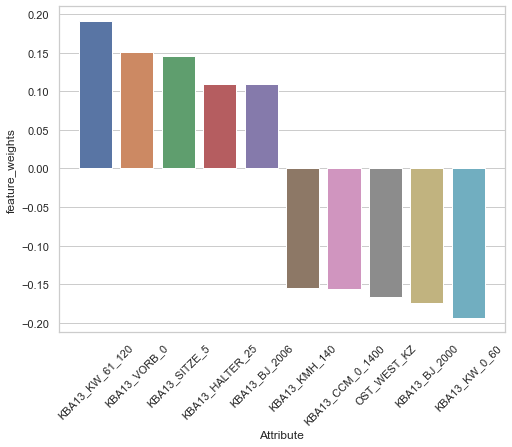

In [111]:
pca_analysis(pca,4,features_list,data_dict)

Component 4: 
1. share of cars with an engine power between 61 very positive weights
2. share of cars with less than 61 KW engine power very negative weights

## Customer Segmentation using Kmeans Clustering Algorithm

In [134]:
kmeans_scores = []

print("Starting Kmeans Testing for different number of clusters !!!")

k_st = 1 ## starting K
k_en = 27 ## ending K
step = 1 ## step valus for tange

## iterating through Kmeans algorithm and calculating the SSD (Sum of squared distance each points to particulat  cluster)
for n in range(k_st, k_en , step):
    
    ## start time
    st_time = time.perf_counter()
    print(f"\n Training for n_clusters:- {n} ",)
    
    ## Kmeans Algorith,
    kmeans = KMeans(n, random_state = rand_seed)
    kmeans.fit(princi_df)
    kmeans_scores.append(kmeans.inertia_)

    print(f"Done! Score: {kmeans_scores[-1]}")
    
    en_time = time.perf_counter()
    print(f" Total elapsed {round((en_time - st_time)/60,2)} min")



Starting Kmeans Testing for different number of clusters !!!

 Training for n_clusters:- 23 
Done! Score: 187965831.8480408
 Total elapsed 4.04 min

 Training for n_clusters:- 24 
Done! Score: 187509409.08566302
 Total elapsed 3.97 min

 Training for n_clusters:- 25 
Done! Score: 186973371.8155251
 Total elapsed 4.42 min

 Training for n_clusters:- 26 
Done! Score: 186562598.366286
 Total elapsed 4.53 min


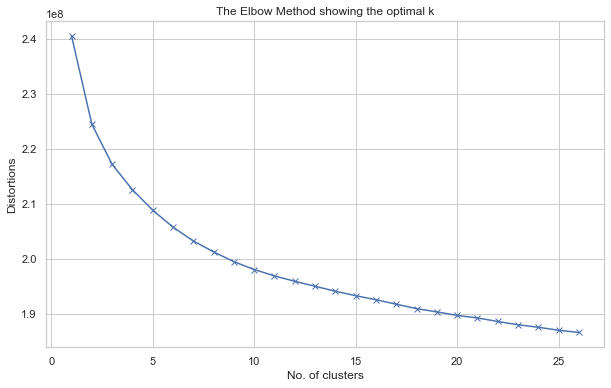

In [137]:
## ploting No of clusters vs distortions value to conclude the Elbow method
fig = plt.figure(figsize=(10,6))

plt.plot(list(range(k_st,k_en)), kmeans_scores, "bx-")
plt.xlabel("No. of clusters")
plt.ylabel("Distortions")
plt.title("The Elbow Method showing the optimal k")

plt.show()

Elbow mathod is used here to select the optimal number of lusters. The above plot is number of clusters between sum of squared distnaces of every point to its respective clusters.
So, from the above plot and according to Elbow mathod we can select the optimal number for the clusters. which is 10. 

In [551]:
## optimal n 
n_optim = 10
kmeans = KMeans(n_optim, random_state = rand_seed)
kmeans.fit(azdias_princi_df)

## predcting clusets
azdias_optim_clusers = kmeans.predict(azdias_princi_df)

In [139]:
## Kmeans predict for customers datasets 
customers_princi_df = pca.transform(customers_df)
customers_optim_clusters = kmeans.predict(customers_princi_df)

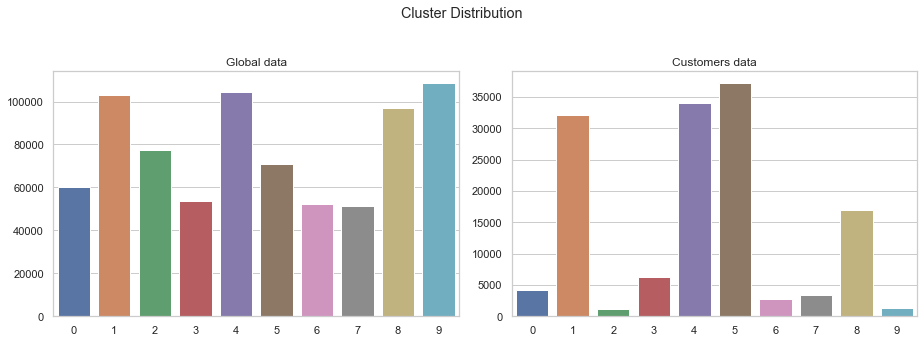

In [157]:
uniqu_values_az , counts_az =  np.unique(azdias_optim_clusers,return_counts=True )
uniqu_values_cu , counts_cu =  np.unique(customers_optim_clusters,return_counts=True )


fig = plt.figure(figsize=(13,5))

ax1 = fig.add_subplot(121)
sns.barplot(uniqu_values_az,counts_az,ax=ax1)

ax1.set_title("Global data");

ax2 = fig.add_subplot(122)
sns.barplot(uniqu_values_cu,counts_cu, ax=ax2)
ax2.set_title("Customers data");

fig.suptitle("Cluster Distribution")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

From Above group we can say that most of the customers are comming from 1,4,8,9 clusters. And also in the customers data that mail order company has given most of the customers are comming from 1,4,5,8. Let's also look at the percentage of population.

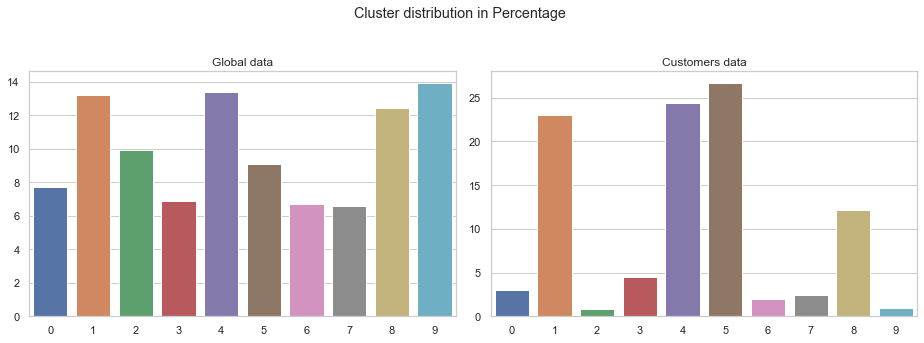

In [167]:
uniqu_values_az , counts_az =  np.unique(azdias_optim_clusers,return_counts=True )
uniqu_values_cu , counts_cu =  np.unique(customers_optim_clusters,return_counts=True )


fig = plt.figure(figsize=(13,5))

ax1 = fig.add_subplot(121)
sns.barplot(uniqu_values_az,counts_az*100/azdias_princi_df.shape[0],ax=ax1,saturation=0.8)

ax1.set_title("Global data");

ax2 = fig.add_subplot(122)
sns.barplot(uniqu_values_cu,counts_cu*100/customers_princi_df.shape[0], ax=ax2,saturation=0.8)
ax2.set_title("Customers data");

fig.suptitle("Cluster distribution in Percentage ")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

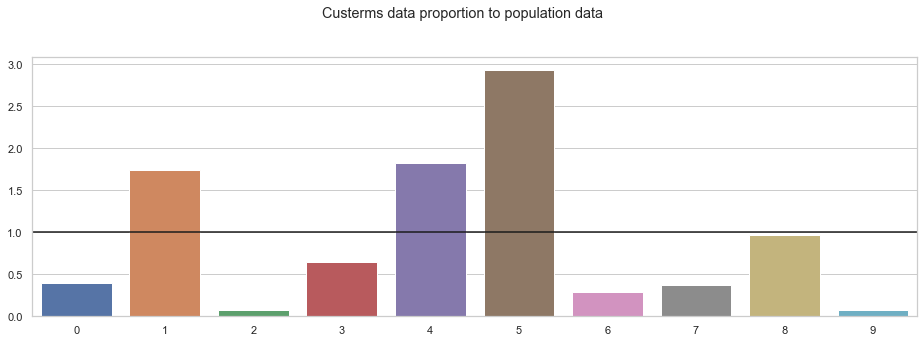

In [186]:

counts_az1 = counts_az*100/azdias_princi_df.shape[0]
counts_cu1 = counts_cu*100/customers_princi_df.shape[0]

fig = plt.figure(figsize=(13,5))

ax1 = fig.add_subplot(111)
sns.barplot(uniqu_values_az,counts_cu1/counts_az1,ax=ax1,saturation=0.8)

ax1.axhline(y=1.0,c="k")
fig.suptitle(" Custerms data proportion to population data ")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

so clusters which have < 1 ratio. we can inference that the customers that belong to those particular clusters are mor likely be our future customers, the mail order company should target those clusters to get the new customers.

##### Let's have a deep look into the clusters  1, 4, 5  and 9 , because they have large number of customers , and check what drives them to be loyal customers or attracted customers

In [221]:
def get_cluster_info(kmeans, pca, cluster_no, features_list, data_dict):
    """
    Function for accuracy report like confusion matrix , f1 score per class and also for whole model and accuracy score
    Args:
        kmeans (object) : Kmeans model object
        pca (object) : PCA Object
        cluster_no (int) : Cluster number
        features_list (list) : list of features
        data_dict (Dataframe) : Data Dictionary 
    Returns:
        combined_compo_df (Dataframe) : Dataframe with component relation with cluster information
    """
    weights = kmeans.cluster_centers_[cluster_no]

    combined_compo_df = pd.DataFrame()
    for compo in range(10):
        compo_df = pca_analysis(pca , compo, features_list, data_dict, draw=False)
        compo_df.loc[:,"cluster_weight"] = weights[compo]
        compo_df.loc[:,"component_no"] = compo
        combined_compo_df = pd.concat([combined_compo_df,compo_df])
    combined_compo_df = combined_compo_df.sort_values(["cluster_weight","feature_weights"], ascending=False)
    
    return combined_compo_df


In [225]:
get_cluster_info(kmeans, pca, 1, features_list, data_dict)


,Attribute,Description,feature_weights,cluster_weight,component_no
242,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.137223,7.426544,0
134,MOBI_REGIO,moving patterns,0.131068,7.426544,0
16,LP_STATUS_GROB,social status rough,0.126746,7.426544,0
76,KBA05_AUTOQUOT,share of cars per household,0.125147,7.426544,0
143,KBA13_AUTOQUOTE,share of cars per household within the PLZ8,0.124844,7.426544,0
39,HH_EINKOMMEN_SCORE,estimated household_net_income,-0.126244,7.426544,0
66,CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,-0.129084,7.426544,0
246,PLZ8_BAUMAX,most common building-type within the PLZ8,-0.130010,7.426544,0
245,PLZ8_ANTG4,number of >10 family houses in the PLZ8,-0.131284,7.426544,0
244,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.136420,7.426544,0


Cluster number 1 includes all the customers features which describes middle class or with big family related

In [227]:
get_cluster_info(kmeans, pca, 4, features_list, data_dict)



,Attribute,Description,feature_weights,cluster_weight,component_no
242,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.137223,3.946159,0
134,MOBI_REGIO,moving patterns,0.131068,3.946159,0
16,LP_STATUS_GROB,social status rough,0.126746,3.946159,0
76,KBA05_AUTOQUOT,share of cars per household,0.125147,3.946159,0
143,KBA13_AUTOQUOTE,share of cars per household within the PLZ8,0.124844,3.946159,0
39,HH_EINKOMMEN_SCORE,estimated household_net_income,-0.126244,3.946159,0
66,CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,-0.129084,3.946159,0
246,PLZ8_BAUMAX,most common building-type within the PLZ8,-0.130010,3.946159,0
245,PLZ8_ANTG4,number of >10 family houses in the PLZ8,-0.131284,3.946159,0
244,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.136420,3.946159,0


Cluster number 2 includes first the same component 0 same as before , but in the next it includes all the luxirious car

In [228]:
get_cluster_info(kmeans, pca, 5, features_list, data_dict)


,Attribute,Description,feature_weights,cluster_weight,component_no
178,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.171538,6.239548,1
211,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.148510,6.239548,1
225,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper cla...,0.145167,6.239548,1
150,KBA13_BMW,share of BMW within the PLZ8,0.141030,6.239548,1
232,KBA13_SITZE_4,number of cars with less than 5 seats in the PLZ8,0.134379,6.239548,1
166,KBA13_HALTER_25,share of car owners between 21 and 25 within t...,-0.116178,6.239548,1
184,KBA13_KMH_180,share of cars with max speed between 110 km/h ...,-0.117108,6.239548,1
186,KBA13_KMH_140_210,share of cars with max speed between 140 and 2...,-0.123954,6.239548,1
220,KBA13_SEG_KLEINWAGEN,share of small and very small cars (Ford Fiest...,-0.125300,6.239548,1
233,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.140848,6.239548,1


Cluster 5 is all about the cars 

In [230]:
get_cluster_info(kmeans, pca, 9, features_list, data_dict)


,Attribute,Description,feature_weights,cluster_weight,component_no
135,ONLINE_AFFINITAET,online affinity,0.158851,0.684401,2
18,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,0.154353,0.684401,2
4,FINANZ_SPARER,financial typology: money saver,0.148591,0.684401,2
7,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,0.134022,0.684401,2
32,SEMIO_PFLICHT,affinity indicating in what way the person is ...,0.125258,0.684401,2
42,D19_GESAMT_DATUM,actuality of the last transaction with the com...,-0.122956,0.684401,2
50,D19_VERSAND_ONLINE_DATUM,actuality of the last transaction for the segm...,-0.125085,0.684401,2
41,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,-0.129412,0.684401,2
5,FINANZ_VORSORGER,financial typology: be prepared,-0.132226,0.684401,2
0,ALTERSKATEGORIE_GROB,age through prename analysis,-0.143569,0.684401,2


This is just a rough analysis to check how each feature is related to components and from there to prticular cluster

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [471]:
def train_and_validate(model, X_train, X_test, y_train, y_test):
    """ 
    This function Train the ML model and validate with the test dataset 
    Args:
        model (model object) : ML model object
        X_train (dataframe) : train dataset
        y_train (Series) : train target dataset
        X_test (dataframe) : test dataset
        y_train (Series) : test target dataset
    Returns:
        roc_auc (float) : Roc AUC score
        time_took : time elapsed
    """
    
    st_time = time.perf_counter()
    
    ## model fitting
    model.fit(X_train, y_train)
    
    ## get the accuracy of the model
    roc_auc = accuracy_report(model, X_test, y_test , unique_labels = y_test.unique() )
    
    en_time = time.perf_counter()
    
    time_took = round((en_time - st_time),2)
    
    return roc_auc, time_took

def accuracy_report(model, X_test, y_test, unique_labels=None):
    """
    Function for accuracy report like accuracy score
    Args:
        model (model object) : ML model object
        X_test (dataframe) : test dataset
        y_train (dataframe) : test target dataset
        unique_labels (list) : list of unique target labels
    Returns:
        roc_auc (float) : Roc AUC score
    """

    ## get the mode predicted probabilitu
    preds_prob = model.predict_proba(X_test)[:,1]
    
    accuracy = roc_auc_score(y_test, preds_prob)
    print(f"roc_auc_score :- {accuracy} ")

    return accuracy



In [386]:
## loading the training data
mailout_train = pd.read_csv('data/Udacity_MAILOUT_TRAIN_052018.csv', sep=';')

/opt/anaconda3/envs/pyds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [387]:
dataset_name = "MAILOUT_TRAIN"
scaled = False

## taking out the LNR columns
target_labels = mailout_train["RESPONSE"]
mailout_LNR_train = mailout_train["LNR"]
mailout_train = mailout_train.drop("RESPONSE",axis=1)

## get the scaled dataset.
if scaled:
    scaled_mailout_train = load_dataset(dataset_name,scaled=True)
    print("Found Scaled Data")
else:
    print("Getting cleaned data")
    scaled_mailout_train,std_scalar, imputer = data_preprocessing(mailout_train, dataset_name , mapping_unknow_values, column_types_dict, std_scalar,imputer, fitted=True, remove_miss_rows = False)


Getting cleaned data
 Total columns :- 366 and total rows :- 42962 
 fixing some Mixed data types ... (2)
 replacing unknonw values to NaN ... (3)
 dropping high percentage missing values by columns ... (4)
 skipped missing values by rows ... (5)
 converting date columns to datetime format ... (6)
 Fixing and encoding values for some columns ... (7)
 removing unnecessary columns ... (8)
 imputing missing values based on 'most frequent' method ... (9)
 Saving cleaned dataset in CSV format ... (10)
 Standardizing all the values from -1 to 1 ... (11)
 Saving scaled dataset in CSV format ... (12)
 Total time took to get scaled MAILOUT_TRAIN dataset is 0.59 mins... 


In [388]:
scaled_mailout_train.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_S

In [389]:
scaled_mailout_train.shape , mailout_train.shape

((42962, 346), (42962, 366))

###### Splitting data into Kfold startified sets

In [390]:
## splitting the datset
X_train, X_test, y_train, y_test = train_test_split( scaled_mailout_train, target_labels, stratify=target_labels, test_size=0.25, random_state=rand_seed )

print(f" Training dataset shape {X_train.shape} ---  Testing dataset shape {X_test.shape} ")

print(np.unique(y_train,return_counts=True))
print(np.unique(y_test,return_counts=True))

 Training dataset shape (32221, 346) ---  Testing dataset shape (10741, 346) 
(array([0, 1]), array([31822,   399]))
(array([0, 1]), array([10608,   133]))


In [474]:
lr_model = LogisticRegression(random_state=rand_seed, max_iter=400)

In [475]:
roc_auc, elapsed_time = train_and_validate(lr_model,X_train, X_test, y_train, y_test)

roc_auc_score :- 0.6660532127830889 


In [467]:
# Different models to try on 
different_models = [("LogisticRegression", LogisticRegression(random_state=rand_seed)),
                     ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=rand_seed)),
                     ("RandomForestClassifier", RandomForestClassifier(random_state=rand_seed)),
                     ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=rand_seed)),
                     ("AdaBoostClassifier", AdaBoostClassifier(random_state=rand_seed)),
                     ("XGBClassifier",xgb.XGBClassifier(random_state=rand_seed))]


In [472]:
results = []
for model_name, model in different_models:
    print("==============")
    print()
    print(f"Trainning on {model_name}")
    roc_auc, elapsed_time = train_and_validate(model,X_train, X_test, y_train, y_test)
    results.append((model_name, roc_auc, elapsed_time))


Trainning on LogisticRegression


/opt/anaconda3/envs/pyds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


roc_auc_score :- 0.6662268652400231 

Trainning on DecisionTreeClassifier
roc_auc_score :- 0.5252246141371529 

Trainning on RandomForestClassifier
roc_auc_score :- 0.5479794650653784 

Trainning on GradientBoostingClassifier
roc_auc_score :- 0.6993810175892219 

Trainning on AdaBoostClassifier
roc_auc_score :- 0.6612394957983193 

Trainning on XGBClassifier
roc_auc_score :- 0.6346029808684607 


In [473]:
results = pd.DataFrame.from_dict(results)
results.columns = ["Model" , "roc_auc" , "elapsed_time(secs)"]
results

,Model,roc_auc,elapsed_time(secs)
0,LogisticRegression,0.666227,0.86
1,DecisionTreeClassifier,0.525225,2.16
2,RandomForestClassifier,0.547979,7.11
3,GradientBoostingClassifier,0.699381,37.63
4,AdaBoostClassifier,0.661239,9.62
5,XGBClassifier,0.634603,52.17


#### We are getting good results from graddient boosting Classsifier  and Interesting Thing is the logistic regressions has good accuracy than RandomForest Classifier 

### Grid Search  With GB Classifier

In [483]:
param_grid = parameters = {
                            "loss":["deviance"],
                            "learning_rate": [0.01, 0.03],
                            "max_depth":[5,8],
                            "criterion": ["mse"],
                            "subsample":[0.8, 0.85, 0.9, 0.95],
                            "n_estimators":[10,25]
                            }

gb_grid = GridSearchCV(estimator = GradientBoostingClassifier(random_state=rand_seed), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)

In [484]:
gb_grid.fit(X_train, y_train)

best_gboost = gb_grid.best_estimator_

print("Best Score: ", gb_grid.best_score_)
print("Best Params: ", gb_grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  7.8min finished


Best Score:  0.6901444874344363
Best Params:  {'criterion': 'mse', 'learning_rate': 0.03, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 25, 'subsample': 0.8}


In [485]:
preds_gboost = best_gboost.predict_proba(X_test)[:,1]

print("ROC score on Test data: {:.4f}".format(roc_auc_score(y_test, preds_gboost)))

joblib.dump(best_adaboost,"models/GradientBoost_best_grid_search_cv.pkl")

ROC score on Test data: 0.7051


['models/GradientBoost_best_grid_search_cv.pkl']

### Grid Search  With ADABOOST Classifier

In [397]:
param_grid = {"n_estimators": [50,100,150,200],
              "learning_rate": [0.01,0.1,0.5,0.9,1.],
              "algorithm":["SAMME.R"]
              }

adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(random_state=rand_seed), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)

In [398]:
adaboost_grid.fit(X_train, y_train)

best_adaboost = adaboost_grid.best_estimator_

print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.1min finished


Best Score:  0.6770569456974054
Best Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.01, 'n_estimators': 200}


In [436]:
preds_adaboost = best_adaboost.predict_proba(X_test)[:,1]

print("ROC score on Test data: {:.4f}".format(roc_auc_score(y_test, preds_adaboost)))


ROC score on Test data: 0.6822


In [416]:
joblib.dump(best_adaboost,"models/ADABoost_best_grid_search_cv.pkl")

['models/ADABoost_best_grid_search_cv.pkl']

### GridSearch with XGBClassifier

In [405]:
xgb_param_grid = {"max_depth": [8,10],
              "learning_rate": [0.01,0.03,0.1],
              "gamma":[0.1,0.5,1.0],
              "n_estimators":[50,100,150,200,500]
              }

xgb_grid = GridSearchCV(estimator = xgb.XGBClassifier(objective="binary:logistic", 
                                                            n_jobs=-1, eval_metric="auc",
                                                            silent=1,random_state=rand_seed), 
                                                               param_grid = xgb_param_grid, 
                                                               scoring = "roc_auc",
                                                               cv = 5, n_jobs = -1, verbose=2)



In [406]:
%%time
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 84.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 193.1min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 256.6min finished


[08:33:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 2min 1s, sys: 926 ms, total: 2min 2s
Wall time: 4h 18min 31s


In [410]:
print("Best Score: ", xgb_grid.best_score_)
print("Best Params: ", xgb_grid.best_params_)

preds_xgb = best_xgb.predict_proba(X_test)[:,1]


Best Score:  0.67559136414084
Best Params:  {'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 200}


In [435]:
print("ROC score on Test data: {}".format(roc_auc_score(y_test, preds_xgb)))


ROC score on Test data: 0.7046005142947867


In [415]:
joblib.dump(best_xgb,"models/XGB_best_grid_search_cv.pkl")

['models/XGB_best_grid_search_cv.pkl']

### XGB Cross validation 

In [427]:
DATA_PATH = "data/"
feature_names = X_train.columns
dump_svmlight_file(X_train, y_train, DATA_PATH + 'dtrain.svm', zero_based=True)
dump_svmlight_file(X_test, y_test, DATA_PATH + 'dtest.svm', zero_based=True)
    
dtrain_svm = xgb.DMatrix(DATA_PATH + 'dtrain.svm',feature_names=feature_names)
dtest_svm = xgb.DMatrix(DATA_PATH + 'dtest.svm',feature_names=feature_names)

[10:25:07] 32221x346 matrix with 11148466 entries loaded from data/dtrain.svm
[10:25:07] 10741x346 matrix with 3716386 entries loaded from data/dtest.svm


In [441]:
objective = "binary:logistic"
eval_matric = "auc"

print(f"Using loss function :- {objective}.. and eval matric :- {eval_matric}..")
xgb_params = {
        'eta': 0.01,
        'max_depth': 8,
        'max_delta_step': 7,
        'min_child_weight' : 5,
        'subsample' : 0.9,
        'colsample_bytree' : 0.9,
        'objective': objective,
        'eval_metric' : eval_matric,
        'n_jobs':-1,
        'verbosity': 0
    }
    
cv_results = xgb.cv(   xgb_params,
                       dtrain_svm,
                       nfold=5,
                       num_boost_round=1000,
                       seed = rand_seed,
                       early_stopping_rounds=10,
                       verbose_eval=10
                      )
    
print("Maximum test avg auc :- {}".format(cv_results['test-auc-mean'].max()))

Using loss function :- binary:logistic.. and eval matric :- auc..
[0]	train-auc:0.52768+0.05535	test-auc:0.51258+0.02516
[10]	train-auc:0.63980+0.07082	test-auc:0.62353+0.06944
[20]	train-auc:0.67076+0.01547	test-auc:0.66247+0.03589
[30]	train-auc:0.67535+0.01323	test-auc:0.66705+0.03988
[40]	train-auc:0.68371+0.01441	test-auc:0.66961+0.03971
[50]	train-auc:0.69395+0.01210	test-auc:0.66755+0.03986
Maximum test avg auc :- 0.671051


In [465]:
n_run_optim =  cv_results[cv_results['test-auc-mean'] ==cv_results['test-auc-mean'].max()].index[0]

optim_xgb = xgb.train(xgb_params , dtrain_svm, num_boost_round=n_run_optim)

preds_optim_xgb = optim_xgb.predict(dtest_svm)

print("ROC score on Test data: {}".format(roc_auc_score(y_test, preds_optim_xgb)))


ROC score on Test data: 0.670919379897708


In [520]:
joblib.dump(optim_xgb,"models/XGB_optim_cv.pkl")

['models/XGB_optim_cv.pkl']

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [487]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_TEST_052018.csv', sep=';')

/opt/anaconda3/envs/pyds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [513]:
dataset_name = "MAILOUT_TEST"
mailout_LNR_test = mailout_test["LNR"].to_frame()

scaled_mailout_test, std_scalar, imputer = data_preprocessing(mailout_test, dataset_name , mapping_unknow_values, column_types_dict, std_scalar,imputer, fitted=True, remove_miss_rows = False)


### load all the best models  and create submissions based on all models

In [536]:
def create_submission(model_path, test_data, submission_df):
    """ 
    This function creates the Kaggle submission file 
    Args:
        model_path (string) : Path for saved model
        test_data (dataframe) : Test Dataset for submission
        submission_df (dataframe) : submission dataframe to add prediction results
    Returns:
        submission_df (dataframe) : including the predicted results
    """
    model = joblib.load(model_path)
    
    preds = model.predict_proba(test_data)[:,1]
        
    submission_df.loc[:,"Response"]  = preds
    
    print(f" Successfully Created Submission ...")
    submission_df.to_csv(f"submissions/{model_path.split('/')[-1].split('.')[0]}.csv",index=False)
    return submission_df

In [539]:
sub_df =   create_submission(model_path="models/XGB_best_grid_search_cv.pkl", test_data = scaled_mailout_test, submission_df= mailout_LNR_test)


 Successfully Created Submission ...


In [540]:
sub_GB_df = create_submission(model_path="models/GradientBoost_best_grid_search_cv.pkl", test_data = scaled_mailout_test, submission_df= mailout_LNR_test)


 Successfully Created Submission ...


In [541]:
sub_AD_df = create_submission(model_path="models/ADABoost_best_grid_search_cv.pkl", test_data = scaled_mailout_test, submission_df= mailout_LNR_test)


 Successfully Created Submission ...


In [547]:
test_df = xgb.DMatrix(scaled_mailout_test ,feature_names=feature_names)

preds_optim_xgb = optim_xgb.predict(test_df)

suboptim_xgb = mailout_LNR_test.copy()
suboptim_xgb.loc[:,"Response"]  = preds_optim_xgb
print(f" Successfully Created Submission ...")
suboptim_xgb.to_csv("submissions/XGB_optim_submissions.csv",index=False)

In [549]:
suboptim_xgb.head()

,LNR,Response
0,1754,0.322543
1,1770,0.324870
2,1465,0.317846
3,1470,0.317846
4,1478,0.318498


###  Kaggle Competition score :- I got pretty much  :- `0.70876`  and `237` Rank
	 